In [3]:
train_df = pd.read_csv('sorghum-fgvc9-png-512/train_cultivar_mapping.csv').dropna()
train_df

,image,cultivar
0,2017-06-21__11-32-09-227.png,PI_152923
1,2017-06-27__10-36-57-694.png,PI_152923
2,2017-06-13__12-10-43-125.png,PI_152923
3,2017-06-03__12-37-57-818.png,PI_152923
4,2017-06-03__12-37-24-028.png,PI_152923
...,...,...
22630,2017-06-04__13-32-11-825.png,PI_152967
22631,2017-06-04__13-33-43-417.png,PI_152967
22632,2017-06-20__12-19-56-066.png,PI_152967
22633,2017-06-09__12-51-11-655.png,PI_152967


# 处理训练集上的异常值

In [4]:
outliers = ['29-33-477', '29-34-965', '29-36-468', '29-43-957', '29-45-460', '29-46-961', '29-48-469', '29-49-960', '29-51-465', '30-06-475', '30-07-971', '30-09-467', '30-59-251', '31-00-751', '31-02-238', '31-17-229', '31-18-730', '31-20-230', '31-21-751', '31-23-234', '31-24-729', '31-30-733', '31-32-233', '31-33-750', '31-35-254']
outliers = list(map(lambda id: f'2017-06-11__13-{id}.png', outliers))

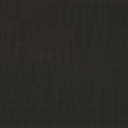

In [5]:
PIL.Image.open(f'{root}/train_images/{outliers[2]}').resize((128, 128))

In [6]:
train_df.drop(train_df[train_df['image'].isin(outliers)].index, inplace=True)
train_df = train_df.dropna().reset_index(drop=True)

In [7]:
actual_images = [img.name for img in (root/'train_images').ls() if img.name in train_df.image.to_list()]
train_df = train_df[train_df.image.isin(actual_images)]
train_df

,image,cultivar
0,2017-06-21__11-32-09-227.png,PI_152923
1,2017-06-27__10-36-57-694.png,PI_152923
2,2017-06-13__12-10-43-125.png,PI_152923
3,2017-06-03__12-37-57-818.png,PI_152923
4,2017-06-03__12-37-24-028.png,PI_152923
...,...,...
22605,2017-06-04__13-32-11-825.png,PI_152967
22606,2017-06-04__13-33-43-417.png,PI_152967
22607,2017-06-20__12-19-56-066.png,PI_152967
22608,2017-06-09__12-51-11-655.png,PI_152967


# 处理测试集上的异常值

无需处理

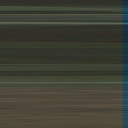

In [8]:
PIL.Image.open(root/f'test/212116519.png').resize((128, 128))

# 数据转换

In [9]:
# 数据处理
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [10]:
# 图像增强处理
import albumentations as A
import torchvision.transforms as T

def get_train_aug(rsz, sz):
    csz = max(8, sz // 50)
    return A.Compose([
        A.CenterCrop(p=1.0, width=512, height=512),
        A.Resize(p=1.0, width=rsz, height=rsz),
        A.RandomCrop(p=1.0, width=sz, height=sz),
        A.Flip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(),
        A.HueSaturationValue(),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.3),
            A.ISONoise(p=0.3),
        ], p=0.25),
        A.OneOf([
            A.GridDropout(ratio=0.33, p=0.1),
            A.CoarseDropout(max_holes=16, min_holes=8, max_height=2*csz, max_width=2*csz, min_height=csz, min_width=csz, p=0.2)
        ], p=0.5),
    ])

def get_valid_aug(size):
    return A.Compose([
        A.Resize(p=1.0, width=size, height=size),
    ])
print(A)

<module 'albumentations' from 'C:\\Users\\jhkvfs\\AppData\\Roaming\\Python\\Python312\\site-packages\\albumentations\\__init__.py'>


In [11]:
print(A)
# from fastai.vision.all import *
# from fastai import *


item_tfms = AlbumentationsTransform(get_train_aug(896, 512), get_valid_aug(512))

dls = ImageDataLoaders.from_df(train_df, root/'train_images',
                               valid_pct=0.3332,
                               fn_col=0, label_col=1,
                               num_workers=64, bs=8,
                               item_tfms=item_tfms,
                               batch_tfms=[Normalize.from_stats(*imagenet_stats)])

<module 'albumentations' from 'C:\\Users\\jhkvfs\\AppData\\Roaming\\Python\\Python312\\site-packages\\albumentations\\__init__.py'>


C:\Users\jhkvfs\AppData\Roaming\Python\Python312\site-packages\fastai\data\transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\jhkvfs\AppData\Roaming\Python\Python312\site-packages\fastai\data\transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
C:\Users\jhkvfs\AppData\Roaming\Python\Python312\site-packages\fastai\data\transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated

C:\Users\jhkvfs\AppData\Roaming\Python\Python312\site-packages\fastai\data\transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


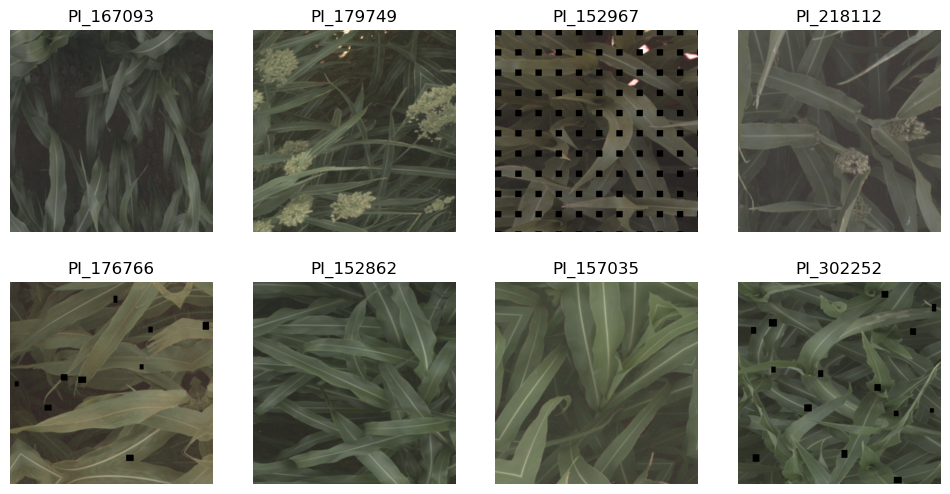

In [12]:
dls.show_batch()

# 模型选择

In [13]:
model = torchvision.models.densenet201

In [14]:
print(model)

<function densenet201 at 0x0000020024345580>


# 加载模型

In [15]:
from fastai.metrics import error_rate, accuracy

model_name = model.__name__
save_dir = Path('.')
save_path = save_dir/model_name
load_path = Path('../input/sorghum-cultivar-100') #/model_name

learn = vision_learner(dls, model, metrics=accuracy, path='.', model_dir='.', loss_func=LabelSmoothingCrossEntropy(0.2))

print('Model name:', model_name)
print('Model load from:', load_path/f'{model_name}.pth')
print('exists? ', (load_path/f'{model_name}.pth').exists())
print('Model save to:', save_path)

if (load_path/f'{model_name}.pth').exists():
    print('Successfully load model from:', load_path/f'{model_name}.pth')
    learn.load(load_path/model_name)

learn.save(model_name)

Model name: densenet201
Model load from: ..\input\sorghum-cultivar-100\densenet201.pth
exists?  False
Model save to: densenet201


Path('densenet201.pth')

In [16]:
learn.summary()

Sequential (Input shape: 8 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 256 x 256  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 128 x 128  
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 128 x 128 x 128 
Conv2d                                    8192       False     
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________

fine_tune(epoch=15)


epoch,train_loss,valid_loss,accuracy,time
0,4.410062,4.206248,0.125102,1:58:17


Better model found at epoch 0 with accuracy value: 0.12510153651237488.


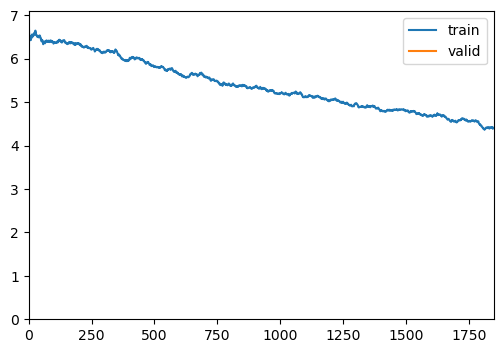

epoch,train_loss,valid_loss,accuracy,time
0,3.652232,3.573616,0.266992,2:44:48
1,3.282500,3.091967,0.424046,2:44:57
2,3.133213,3.134991,0.426889,2:45:31
3,2.975740,2.865298,0.503385,2:47:11
4,2.860405,2.914024,0.489169,2:50:32
5,2.744307,2.784979,0.575142,2:49:37
6,2.642232,2.746752,0.587869,2:49:00
7,2.499865,2.769701,0.582724,2:49:23
8,2.430872,2.522791,0.671812,2:49:29
9,2.322508,2.446975,0.701868,2:49:25


Better model found at epoch 0 with accuracy value: 0.26699161529541016.


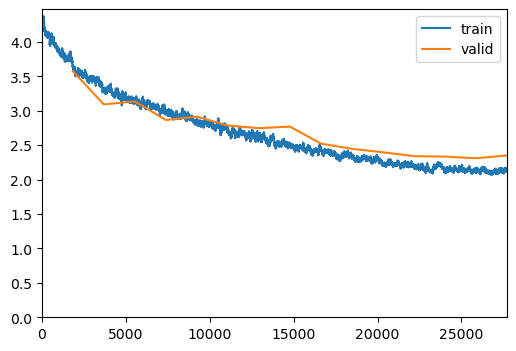

Better model found at epoch 1 with accuracy value: 0.42404550313949585.
Better model found at epoch 2 with accuracy value: 0.42688870429992676.
Better model found at epoch 3 with accuracy value: 0.5033847689628601.
Better model found at epoch 5 with accuracy value: 0.5751421451568604.
Better model found at epoch 6 with accuracy value: 0.5878689289093018.
Better model found at epoch 8 with accuracy value: 0.6718115210533142.
Better model found at epoch 9 with accuracy value: 0.7018684148788452.
Better model found at epoch 10 with accuracy value: 0.7342269420623779.
Better model found at epoch 11 with accuracy value: 0.7557541131973267.
Better model found at epoch 13 with accuracy value: 0.7646899819374084.


In [22]:
EPOCHS = 15
print(f'fine_tune(epoch={EPOCHS})')
learn.fine_tune(EPOCHS, cbs=[
    ShowGraphCallback(),
    TerminateOnNaNCallback(),
    SaveModelCallback(monitor='accuracy', min_delta=0.1/100, fname=model_name), # +0.1% accuracy
    EarlyStoppingCallback(patience=10),
])

# 预测

In [23]:
learn.predict(root/'test/1000005362.png')

('PI_154750',
 tensor(25),
 tensor([0.0038, 0.0047, 0.0014, 0.0016, 0.0022, 0.0139, 0.0030, 0.0042, 0.0026,
         0.0664, 0.0021, 0.0012, 0.0031, 0.0038, 0.0049, 0.0016, 0.0038, 0.0012,
         0.0054, 0.0029, 0.0037, 0.0013, 0.0028, 0.0071, 0.0049, 0.1724, 0.0085,
         0.0940, 0.0011, 0.0004, 0.0014, 0.0244, 0.0103, 0.0076, 0.0054, 0.0032,
         0.0143, 0.0010, 0.0008, 0.0028, 0.0020, 0.0084, 0.0046, 0.0084, 0.0015,
         0.0044, 0.0162, 0.0038, 0.0016, 0.0014, 0.0049, 0.0269, 0.0380, 0.0047,
         0.0006, 0.0151, 0.0189, 0.0021, 0.0039, 0.0072, 0.0016, 0.0011, 0.1121,
         0.0023, 0.0043, 0.0006, 0.0046, 0.0058, 0.0411, 0.0069, 0.0023, 0.0010,
         0.0034, 0.0093, 0.0044, 0.0018, 0.0016, 0.0013, 0.0167, 0.0060, 0.0012,
         0.0042, 0.0030, 0.0092, 0.0093, 0.0161, 0.0023, 0.0017, 0.0055, 0.0036,
         0.0017, 0.0040, 0.0019, 0.0017, 0.0113, 0.0035, 0.0023, 0.0018, 0.0056,
         0.0061]))

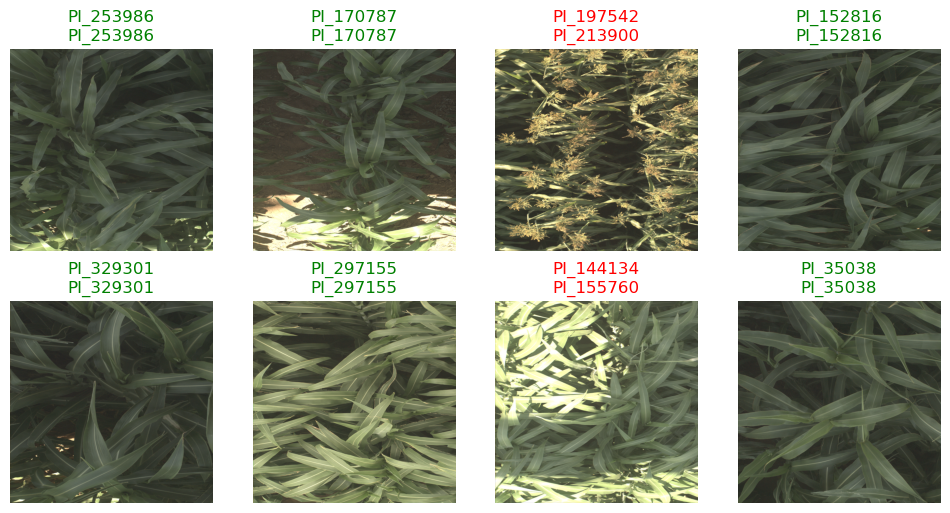

In [24]:
learn.show_results(max_n=12)

In [25]:
test_images = get_image_files(root/'test')
test_dataloader = learn.dls.test_dl(test_images)
preds, _ = learn.get_preds(dl=test_dataloader)
class_idxs = [pred.argmax(dim=0) for pred in preds]

In [26]:
results = [dls.vocab[i] for i in class_idxs]
len(test_images), len(results)

(23639, 23639)

In [27]:
image_names = list(map(lambda s: str(s).split('/')[-1], test_images))
submissions = pd.DataFrame(list(zip(image_names, results)), columns=['filename', 'cultivar']).sort_values(by='filename')
submissions.head()

,filename,cultivar
0,sorghum-fgvc9-png-512\test\1000005362.png,PI_154750
1,sorghum-fgvc9-png-512\test\1000099707.png,PI_329333
2,sorghum-fgvc9-png-512\test\1000135300.png,PI_92270
3,sorghum-fgvc9-png-512\test\1000136796.png,PI_329256
4,sorghum-fgvc9-png-512\test\1000292439.png,PI_155760


In [28]:
submissions.to_csv('submission.csv', index=False)